In [1]:
#!/usr/bin/env python
# coding: utf-8

import argparse
import torch
import transformers 
from model_lib.hf_tooling import HF_LM
from tqdm import tqdm
from hooks import *
import numpy as np

import pandas as pd
from easydict import EasyDict as edict
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
import numpy as np
import seaborn as sns
from scipy import stats
from rare_knowledge.collection import *


/home/t-merty/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, auc

def find_sub_list(sl,l, offset=0):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if ind < offset:
            continue
        if l[ind:ind+sll]==sl:
            return ind,ind+sll-1

def find_within_text(prompt, parts, tokenizer):
    """
    A function that identifies the indices of tokens of a part of the prompt. 
    By default we use the first occurence. 
    """
    prompt_tokens = tokenizer.encode(prompt)
    part_tokens = [tokenizer.encode(p)[2:] for p in parts]
    part_token_indices = [find_sub_list(pt, prompt_tokens) for pt in part_tokens]
    return part_token_indices

In [3]:
tokenizer = transformers.AutoTokenizer.from_pretrained("meta-llama/Llama-2-13b-hf")

In [152]:
from collections import defaultdict
def extract_predictors(records):
    norms = records.norms
    att_weigts = records.att_ws
    indices = np.arange(len(norms))
    corr = []
    predictors = defaultdict(list)
    
    for token_head_norms, idx in zip(norms, indices):
        prompt = records["prompt"][idx]
        filler_indices = find_within_text(prompt, [" "+records["name"][idx]], tokenizer)[0]
        max_norms = token_head_norms[:].sum(axis=(1)).max(axis=1)
        max_weights = att_weigts[idx].max(axis=1).max(axis=1)
        corr.append(int(records["gt_logprob"][idx]==records["pred_logprob"][idx]))
        predictors[r"$||a_{c,g}^{\ell, [h]}||$"].append(token_head_norms[:].max(axis=2).reshape((1, -1)))
        #predictors[r"$||a_{C,g}^{\ell, [h]}||$"].append(token_head_norms[:, :, -1].reshape((1, -1)))
        predictors[r"$||A_{c,g}^{\ell, [h]}||$"].append(att_weigts[idx].max(axis=2).reshape((1, -1)))
        #predictors[r"$||A_{C,g}^{\ell, [h]}||$"].append(att_weigts[idx][:, :, -1].reshape((1, -1)))
        
    predictors = {k: np.array(v) for k,v in predictors.items()}
    predictors[r"$\hat{P}(\hat{Y}|X)$"] = np.array(records["pred_logprob"])
    y = np.array(corr)
    predictors["Majority"] = np.ones(y.shape[0]) if np.mean(y) > 0.5 else np.zeros(y.shape[0])
    return predictors, y

In [153]:
def get_metrics(y, score):
    ## TODO: Add risk @ top 20% coverage
    ## TODO: Add risk @ bottom 20%
    roc_auc = roc_auc_score(y, score)
    precision, recall, _ = precision_recall_curve(y, score)
    pr_auc = auc(recall, precision)
    bottom20_idx = np.argsort(score)[:int(score.shape[0]*0.2)]
    top20_idx =  np.argsort(-score)[:int(score.shape[0]*0.2)]
    risk_at_top20 = 1-y[top20_idx].mean()
    risk_at_bottom20 = 1-y[bottom20_idx].mean()

    accuracy = (y == (score >= 0.5)).mean()
    return {r"AUROC$\textcolor{Green}{\mathbf{(\Uparrow)}}$": roc_auc, 
            r"$\text{Risk}_{[q_{0.8}, q_{1.0}]}\textcolor{Red}{\mathbf{(\Downarrow)}}$": risk_at_top20, 
            r"$\text{Risk}_{[q_{0.0}, q_{0.2}]}\textcolor{Green}{\mathbf{(\Uparrow)}}$":risk_at_bottom20}

    

In [154]:
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Lasso

data_pretty = {"songs": "Songs", "movies": "Movies", "football_teams": "Football Teams", "basketball_players": "Basketball Players",
              "schools" : "Schools", "counterfact": "CounterFact",
                'counterfact_mother_tongue': 'CounterFact',
                'counterfact_official_religion': 'CounterFact',
                'counterfact_twin_city': 'CounterFact',
                'counterfact_capital': 'CounterFact',
                'counterfact_citizenship': 'CounterFact',
                'counterfact_language_used': 'CounterFact',
                'counterfact_original_language': 'CounterFact',
                'counterfact_headquarter_location': 'CounterFact'
              }
constraint_names = {"songs": r"\textit{performed by}",
                    "movies": r"\textit{directed by}",
                    "football_teams": r"\textit{founded in the year}",
                    "basketball_players": r"\textit{born in the year}",
                    "schools": r"\textit{founded in the year}",
                    "counterfact": r"mixed",
                    'counterfact_mother_tongue': r"\textit{Mother Tongue}",
                    'counterfact_official_religion': r"\textit{Official Religion}",
                    'counterfact_twin_city': r"\textit{Twin City}",
                    'counterfact_capital': r"\textit{Capital}",
                    'counterfact_citizenship': r"\textit{Citizenship}",
                    'counterfact_language_used': r"\textit{Language Used}",
                    'counterfact_original_language': r"\textit{Original Language}",
                    'counterfact_headquarter_location': r"\textit{Headquarter Location}"
                   }


In [170]:
for data_name in ["basketball_players", "songs", "movies", "football_teams", "schools", 
                      'counterfact_mother_tongue', 
                      'counterfact_official_religion', 
                      'counterfact_citizenship', 
                      'counterfact_original_language', 
                      'counterfact_headquarter_location']:
    for model_size in ["7b", "13b", "70b"]:
        
        filename = f"/home/t-merty/mounts/sandbox-mert/Llama-2-{model_size}-hf_{data_name}_finalrun.pkl"
        if not os.path.exists(filename):
            print(filename, "damn")
        else:
            records = edict(pickle.load(open(filename, "rb")))
            print(data_name, model_size, len(records.prompt))

basketball_players 7b 10000
basketball_players 13b 10000
basketball_players 70b 10000
songs 7b 2800
songs 13b 2800
songs 70b 2550
movies 7b 9828
movies 13b 9828
movies 70b 6088
football_teams 7b 8800
football_teams 13b 8800
football_teams 70b 8800
schools 7b 3450
schools 13b 3450
schools 70b 2500
counterfact_mother_tongue 7b 900
counterfact_mother_tongue 13b 900
counterfact_mother_tongue 70b 900
counterfact_official_religion 7b 400
counterfact_official_religion 13b 400
counterfact_official_religion 70b 400
counterfact_citizenship 7b 950
counterfact_citizenship 13b 950
counterfact_citizenship 70b 950
counterfact_original_language 7b 750
counterfact_original_language 13b 750
counterfact_original_language 70b 750
counterfact_headquarter_location 7b 738
counterfact_headquarter_location 13b 738
counterfact_headquarter_location 70b 738


In [171]:
all_predictors = defaultdict(dict)
all_labels = defaultdict(dict)

In [172]:

result_records = []
for model_size in ["7b", "13b", "70b"]:
    for data_name in ["basketball_players", "songs", "movies", "football_teams", "schools", 
                      'counterfact_mother_tongue', 
                      'counterfact_official_religion', 
                      'counterfact_citizenship', 
                      'counterfact_original_language', 
                      'counterfact_headquarter_location']:
        print(model_size, data_name)
        filename = f"/home/t-merty/mounts/sandbox-mert/Llama-2-{model_size}-hf_{data_name}_finalrun.pkl"
        if not os.path.exists(filename):
            continue
        records_to_save = edict(pickle.load(open(filename, "rb")))
        records = records_to_save
        if "counterfact" not in data_name:
            filter = (np.array(records.popularity)>=15).nonzero()[0]
        else:
            filter = (np.array(records.popularity)>=-np.inf).nonzero()[0]
        for k, v in records.items():
            records[k] = [records_to_save[k][f] for f in filter]
        predictors, y = extract_predictors(records)
        y = y.reshape((-1))
        all_labels[model_size][data_name] = y
        all_predictors[model_size][data_name] = predictors
        
        train_idx, test_idx, y_train, y_test = train_test_split(np.arange(y.shape[0]), y, test_size=0.5, stratify=y)
        print(data_name)
        
        for predictor in predictors:
            X_train = predictors[predictor][train_idx].reshape((y_train.shape[0], -1))
            X_test = predictors[predictor][test_idx].reshape((y_test.shape[0], -1))
            lr = LogisticRegression(max_iter=10000)
            lr.fit(X_train, y_train)
            score = lr.predict_proba(X_test)[:, 1]
            metrics = get_metrics(y_test, score)
            print(y_train.shape[0], y_test.shape[0])
            print(predictor, metrics)
            print()
            result_records.append({"Model Size": model_size, 
                                   "Constraint": constraint_names[data_name],
                                   "Data": rf"{data_pretty[data_name]}", 
                                   "BaseRate": y_test.mean(), 
                                   "Predictor": predictor, 
                                   **metrics})
df_results = pd.DataFrame(result_records)

7b basketball_players
basketball_players
1005 1006
$||a_{c,g}^{\ell, [h]}||$ {'AUROC$\\textcolor{Green}{\\mathbf{(\\Uparrow)}}$': 0.8111951193457645, '$\\text{Risk}_{[q_{0.8}, q_{1.0}]}\\textcolor{Red}{\\mathbf{(\\Downarrow)}}$': 0.14925373134328357, '$\\text{Risk}_{[q_{0.0}, q_{0.2}]}\\textcolor{Green}{\\mathbf{(\\Uparrow)}}$': 0.8805970149253731}

1005 1006
$||A_{c,g}^{\ell, [h]}||$ {'AUROC$\\textcolor{Green}{\\mathbf{(\\Uparrow)}}$': 0.8486229639212987, '$\\text{Risk}_{[q_{0.8}, q_{1.0}]}\\textcolor{Red}{\\mathbf{(\\Downarrow)}}$': 0.14427860696517414, '$\\text{Risk}_{[q_{0.0}, q_{0.2}]}\\textcolor{Green}{\\mathbf{(\\Uparrow)}}$': 0.9054726368159204}

1005 1006
$\hat{P}(\hat{Y}|X)$ {'AUROC$\\textcolor{Green}{\\mathbf{(\\Uparrow)}}$': 0.8991030769169901, '$\\text{Risk}_{[q_{0.8}, q_{1.0}]}\\textcolor{Red}{\\mathbf{(\\Downarrow)}}$': 0.014925373134328401, '$\\text{Risk}_{[q_{0.0}, q_{0.2}]}\\textcolor{Green}{\\mathbf{(\\Uparrow)}}$': 0.9104477611940298}

1005 1006
Majority {'AUROC$\\t

In [130]:
result_records = []

for model_size, model_predictors in all_predictors.items():

    for data_name, predictors in model_predictors.items():
        y = all_labels[model_size][data_name]

        for seed in range(1, 11):
            train_idx, test_idx, y_train, y_test = train_test_split(np.arange(y.shape[0]), y, test_size=0.5, stratify=y, random_state=seed)
    
            for predictor, array in predictors.items():
                X_train = array[train_idx].reshape((y_train.shape[0], -1))
                X_test = array[test_idx].reshape((y_test.shape[0], -1))
                
                lr = LogisticRegression(max_iter=10000)
                lr.fit(X_train, y_train)
                score = lr.predict_proba(X_test)[:, 1]
                metrics = get_metrics(test_labels[data_name], score)
                print(predictor, metrics)
                print(get_metrics(y_train, lr.predict_proba(X_train)[:, 1]))
                print()
                result_records.append({"Model Size": model_size, 
                                       "Constraint": constraint_names[data_name],
                                       "Data": rf"{data_pretty[data_name]}", 
                                       "BaseRate": y_test.mean(), 
                                       "Predictor": predictor, 
                                       "Seed": seed,
                                       **metrics})
    
        

$||a_{C,g}^{\ell, [h]}||$ {'AUROC$\\textcolor{Green}{\\mathbf{(\\Uparrow)}}$': 0.8371572246422396, '$\\text{Risk}_{[q_{0.8}, q_{1.0}]}\\textcolor{Red}{\\mathbf{(\\Downarrow)}}$': 0.08457711442786064, '$\\text{Risk}_{[q_{0.0}, q_{0.2}]}\\textcolor{Green}{\\mathbf{(\\Uparrow)}}$': 0.8855721393034826}
{'AUROC$\\textcolor{Green}{\\mathbf{(\\Uparrow)}}$': 0.9034190473925006, '$\\text{Risk}_{[q_{0.8}, q_{1.0}]}\\textcolor{Red}{\\mathbf{(\\Downarrow)}}$': 0.03980099502487566, '$\\text{Risk}_{[q_{0.0}, q_{0.2}]}\\textcolor{Green}{\\mathbf{(\\Uparrow)}}$': 0.9601990049751243}

$||a_{C,g}^{\ell, [h]}||$ {'AUROC$\\textcolor{Green}{\\mathbf{(\\Uparrow)}}$': 0.7306622257053292, '$\\text{Risk}_{[q_{0.8}, q_{1.0}]}\\textcolor{Red}{\\mathbf{(\\Downarrow)}}$': 0.296875, '$\\text{Risk}_{[q_{0.0}, q_{0.2}]}\\textcolor{Green}{\\mathbf{(\\Uparrow)}}$': 0.875}
{'AUROC$\\textcolor{Green}{\\mathbf{(\\Uparrow)}}$': 0.9824255485893417, '$\\text{Risk}_{[q_{0.8}, q_{1.0}]}\\textcolor{Red}{\\mathbf{(\\Downarrow)}}

In [163]:
df_results = pd.DataFrame(result_records)
df_results = df_results[df_results.Predictor != r"$||a_{c,g}^{\ell, [h]}||$"]

In [164]:
# Pivot table to get desired format
pivot_df = df_results.pivot_table(index=['Model Size', 'Data', 'Constraint', "BaseRate"], 
                                                           columns='Predictor', 
                                                           values=list(df_results.columns[4:]), aggfunc='first')
pivot_df.reset_index(inplace=True)


In [165]:
def generate_latex_with_multicolumns(df, metrics, predictors, plot_header=False):
    # Generate initial LaTeX table
    latex_str = df.to_latex(index=False, float_format=lambda x: f"${x:.2f}$")

    
    # Find the line with the headers
    lines = latex_str.split('\n')
    header_line_idx = 2
    
    # Create multicolumn headers and new column format
    multicolumn_headers = ' & '.join([f'\\multicolumn{{{len(predictors)}}}{{c|}}{{{metric}}}' for metric in metrics])
    new_col_format = "|c|c|c|c|" + "|c|c|c|c|" * len(metrics)
    
    # Insert multicolumn headers and adjust column format
    lines[header_line_idx] = f' Model & Data & Constraint & Model Success & {multicolumn_headers} \\\\'
    lines[0] = f'\\begin{{tabular}}{{{new_col_format}}}'
    lines.insert(header_line_idx+1,"\\midrule")
    lines.insert(0, "\\begin{adjustbox}{width=\\textwidth}")
    lines.insert(-1, "\\end{adjustbox}")
    if plot_header:
        return '\n'.join(lines[:-3])
    else:
        return '\n'.join(lines[6:-3])


# List of metrics
metrics = list()
for v in pivot_df.columns.values[4:]:
    if v[0] not in metrics:
        metrics.append(v[0])
predictors = df_results.Predictor.unique()
# Generate LaTeX table with multicolumn headers

for j, model_size in enumerate(["7b", "13b", "70b"]):
    sub_df = pivot_df[pivot_df['Model Size'] == model_size]
    modified_latex_str = generate_latex_with_multicolumns(sub_df, metrics, predictors, plot_header = (j==0))
    print(modified_latex_str)
print(r"\end{tabular}")
print(r"\end{adjustbox}")


\begin{adjustbox}{width=\textwidth}
\begin{tabular}{|c|c|c|c||c|c|c|c||c|c|c|c||c|c|c|c|}
\toprule
 Model & Data & Constraint & Model Success & \multicolumn{3}{c|}{$\text{Risk}_{[q_{0.0}, q_{0.2}]}\textcolor{Green}{\mathbf{(\Uparrow)}}$} & \multicolumn{3}{c|}{$\text{Risk}_{[q_{0.8}, q_{1.0}]}\textcolor{Red}{\mathbf{(\Downarrow)}}$} & \multicolumn{3}{c|}{AUROC$\textcolor{Green}{\mathbf{(\Uparrow)}}$} \\
\midrule
 &  &  &  & $\hat{P}(\hat{Y}|X)$ & $||A_{c,g}^{\ell, [h]}||$ & Majority & $\hat{P}(\hat{Y}|X)$ & $||A_{c,g}^{\ell, [h]}||$ & Majority & $\hat{P}(\hat{Y}|X)$ & $||A_{c,g}^{\ell, [h]}||$ & Majority \\
\midrule
7b & Basketball Players & \textit{born in the year} & $0.52$ & $0.90$ & $0.90$ & $0.46$ & $0.01$ & $0.15$ & $0.46$ & $0.88$ & $0.83$ & $0.50$ \\
7b & CounterFact & \textit{Citizenship} & $0.62$ & $0.46$ & $0.68$ & $0.38$ & $0.27$ & $0.17$ & $0.38$ & $0.50$ & $0.72$ & $0.50$ \\
7b & CounterFact & \textit{Headquarter Location} & $0.61$ & $0.77$ & $0.88$ & $0.36$ & $0.07$ & $0.

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, auc
from kondo import use_style; use_style(palette="bmh")


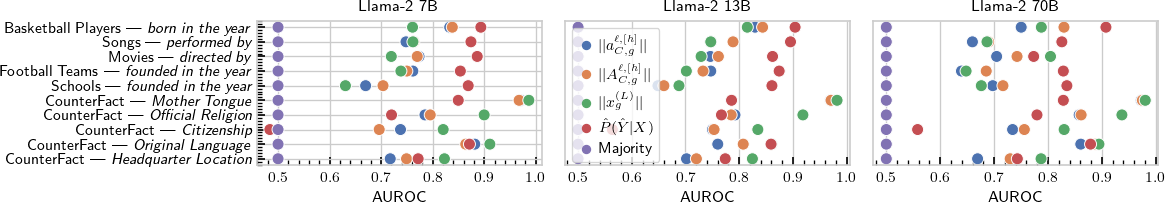

In [151]:
sns.set_context("paper")
sns.set_palette("deep")
df_results_cp = df_results.copy()
df_results_cp["AUROC"] = df_results_cp[r"AUROC$\textcolor{Green}{\mathbf{(\Uparrow)}}$"]
for metric in ["AUROC"]:

    df_results_cp["DS+C"] = df_results_cp.apply(lambda x: x["Data"]+" | "+x["Constraint"], axis=1)
    fig, axs = plt.subplots(1, 3, figsize=(10, 2))
    for i, ms in enumerate(df_results_cp["Model Size"].unique()):
        df_results_model = df_results_cp[df_results_cp["Model Size"] == ms]
        model = f"Llama-2 {ms.upper()}"
        ax = axs[i]
        axs[i].set_title(model)
        sns.scatterplot(data=df_results_model, x=metric,y="DS+C",  hue="Predictor", s=52, ax=ax)
        if i != 0:
            ax.set_yticks([])
    
        if i != 1:
            ax.get_legend().remove()
        
        if i == 1:
            ax.legend(loc="upper left")
        
        ax.set_ylabel("")
    
    fig.tight_layout()
    fig.savefig(f"./figures/figure5_{metric}.pdf")

## Generalization Q

In [141]:
result_records = []
for model_size, model_predictors in all_predictors.items():
    train_data = defaultdict(list)
    train_labels = []
    test_data = defaultdict(dict)
    test_labels = dict()
    for data_name, predictors in model_predictors.items():
        y = all_labels[model_size][data_name]
        train_idx, test_idx, y_train, y_test = train_test_split(np.arange(y.shape[0]), y, test_size=0.5, stratify=y)
        train_labels.append(y_train)
        for predictor, array in predictors.items():
            train_data[predictor].append(array[train_idx].reshape((y_train.shape[0], -1)))
            test_data[predictor][data_name] = array[test_idx].reshape((y_test.shape[0], -1))
            test_labels[data_name] = y_test
            
            
    for predictor in train_data:
        X_train = np.concatenate(train_data[predictor])
        lr = LogisticRegression(max_iter=10000)
        y_train = np.concatenate(train_labels)
        lr.fit(X_train, y_train)

        for data_name in test_data[predictor]:
            X_test = test_data[predictor][data_name]
            score = lr.predict_proba(X_test)[:, 1]
            metrics = get_metrics(test_labels[data_name], score)
            print(predictor, metrics)
            print()
            result_records.append({"Model Size": model_size, 
                                   "Constraint": constraint_names[data_name],
                                   "Data": rf"{data_pretty[data_name]}", 
                                   "BaseRate": y_test.mean(), 
                                   "Predictor": predictor, 
                                   **metrics})
df_results = pd.DataFrame(result_records)
        

$||a_{C,g}^{\ell, [h]}||$ {'AUROC$\\textcolor{Green}{\\mathbf{(\\Uparrow)}}$': 0.8600451824508512, '$\\text{Risk}_{[q_{0.8}, q_{1.0}]}\\textcolor{Red}{\\mathbf{(\\Downarrow)}}$': 0.09950248756218905, '$\\text{Risk}_{[q_{0.0}, q_{0.2}]}\\textcolor{Green}{\\mathbf{(\\Uparrow)}}$': 0.900497512437811}

$||a_{C,g}^{\ell, [h]}||$ {'AUROC$\\textcolor{Green}{\\mathbf{(\\Uparrow)}}$': 0.7809561128526645, '$\\text{Risk}_{[q_{0.8}, q_{1.0}]}\\textcolor{Red}{\\mathbf{(\\Downarrow)}}$': 0.28125, '$\\text{Risk}_{[q_{0.0}, q_{0.2}]}\\textcolor{Green}{\\mathbf{(\\Uparrow)}}$': 0.90625}

$||a_{C,g}^{\ell, [h]}||$ {'AUROC$\\textcolor{Green}{\\mathbf{(\\Uparrow)}}$': 0.7691257849848661, '$\\text{Risk}_{[q_{0.8}, q_{1.0}]}\\textcolor{Red}{\\mathbf{(\\Downarrow)}}$': 0.14460285132382888, '$\\text{Risk}_{[q_{0.0}, q_{0.2}]}\\textcolor{Green}{\\mathbf{(\\Uparrow)}}$': 0.7729124236252546}

$||a_{C,g}^{\ell, [h]}||$ {'AUROC$\\textcolor{Green}{\\mathbf{(\\Uparrow)}}$': 0.7432418147931792, '$\\text{Risk}_{[q_{0.

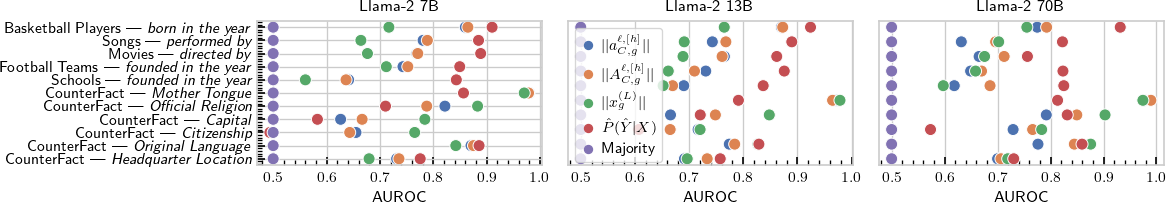

In [145]:
sns.set_context("paper")
sns.set_palette("deep")
df_results_cp = df_results.copy()
df_results_cp["AUROC"] = df_results_cp[r"AUROC$\textcolor{Green}{\mathbf{(\Uparrow)}}$"]
for metric in ["AUROC"]:

    df_results_cp["DS+C"] = df_results_cp.apply(lambda x: x["Data"]+" | "+x["Constraint"], axis=1)
    fig, axs = plt.subplots(1, 3, figsize=(10, 2))
    for i, ms in enumerate(df_results_cp["Model Size"].unique()):
        df_results_model = df_results_cp[df_results_cp["Model Size"] == ms]
        model = f"Llama-2 {ms.upper()}"
        ax = axs[i]
        axs[i].set_title(model)
        sns.scatterplot(data=df_results_model, x=metric,y="DS+C",  hue="Predictor", s=52, ax=ax)
        #sns.barplot(data=df_results_model, x=metric,y="DS+C",  hue="Predictor", ax=ax)

        if i != 0:
            ax.set_yticks([])
    
        if i != 1:
            ax.get_legend().remove()
        
        if i == 1:
            ax.legend(loc="upper left")
        
        ax.set_ylabel("")
    
    fig.tight_layout()
    fig.savefig(f"./figures/figure5_{metric}.pdf")